# CNN + MaxPool
Restructure code.
Here, make sure we can do loops of train+test using all of both files.

TO DO: pass validation data to fit().

In [1]:
from datetime import datetime
print(datetime.now())

2023-03-16 01:22:15.104087


In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
print(DATA_DIR)

Found GPU at: /device:GPU:0
Running on CoLab
Mounted at /content/drive/
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [3]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
CFILTERS=64
FILTERSIZE=16
RCELLS=32
DCELLS=16
EPOCHS=12
EMBED_DIMEN = 4 # arbitrary hyperparameter
MINLEN=200
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'RCI_GMM'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
NUM_LINES = 15   # 15 to analyze all of them

Python 3.9.16
sklearn 1.2.2


In [4]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.csv'
RCI_FILE_VALID = 'train.lncRNA_RCI.csv'
RCI_FILE_TEST  = None # else 'test.lncRNA_RCI.csv'

SEQ_FILE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_VALID = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None # else 'test.canon_lncRNA_transcripts.csv'

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC

## Data Load

In [6]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = np.power(values,2)
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = 0.0
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    if seq_len>=MINLEN and seq_len<=MAXLEN \
                    and gene_id in self.gene2rci.keys():
                        allids.append( (gene_id,tran_id) )
                        if seq_len<MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                            seq_txt = seq_txt[:MAXLEN]
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

## Model

In [7]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    cnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    pool_layer = MaxPooling1D(pool_size=FILTERSIZE, strides=FILTERSIZE//2)
    flat_layer = Flatten()
    dens_layer = Dense(DCELLS)
    drop_layer = Dropout(0.5)
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    cnn.add(embed_layer)
    cnn.add(cnn1_layer)
    cnn.add(pool_layer)
    cnn.add(flat_layer)
    cnn.add(dens_layer)
    cnn.add(drop_layer)
    cnn.add(output_layer)

    bc=BinaryCrossentropy(from_logits=False)
    cnn.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return cnn

In [8]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-03-16 01:22:51.214711
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 4997, 4)           1028      
                                                                 
 conv1d (Conv1D)             (None, 4982, 64)          4160      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 621, 64)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 39744)             0         
                                                                 
 dense (Dense)               (None, 16)                635920    
                                                                 
 dropout (Dropout)           (None, 16)                0         
                             

## Training

In [9]:
import gc
class CrossValidator():
    def __init__(self,epochs,quick_test=False,score_threshold=0.5):
        self.epochs = epochs
        self.quick_test = quick_test
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def set_sequences(self, allids, allseq):
        # Keep IDs and sequences in same order.
        self.all_ids = allids  # pairs of (gene_id,tran_id)
        self.all_seqs = allseq  # may be vectors of K-mers
            
    def set_rci_map(self, gene_to_rci):
        # The map is for fast lookup, not gene order.
        self.rci_map = gene_to_rci # map gene_id to RCI value
    
    def _get_X_y(self, exclude_middle=False): # to do: validation subset
        subsetX=[]
        subsetY=[]
        for t in range(len(self.all_ids)):
            gene_id,tran_id = self.all_ids[t]
            oneX            = self.all_seqs[t]
            oneY            = self.rci_map[gene_id]
            if exclude_middle and oneY >= -2 and oneY <= 0:
                # Exclude middle from train set only, for comparison to Yuan et al
                continue
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def train_new_model(self):
        print(datetime.now())
        X_train,y_rci = self._get_X_y() 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        y_rci = None
        cw = class_weight.compute_class_weight(
            'balanced', classes=[0,1], y=y_train)
        cwd = {0: cw[0], 1: cw[1]}

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd) # validation_data=(X_valid,y_valid) ) 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y() 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)
        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.2f%%' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [10]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            if gene_id in self.val_genes:
                self.val_ids.append(allids[t])
                self.val_seq.append(allseq[t])
                self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                self.train_ids.append(allids[t])
                self.train_seq.append(allseq[t])
                self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-03-16 01:22:51.559037
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv
Loaded 4236 sequences.
2023-03-16 01:23:01.567826

Training # 1 1
2023-03-16 01:23:01.568024
2023-03-16 01:23:01.568080
Discriminator is GMM
Means [1.7687240563756081, -0.6265731768958065]
Variances [ 2.85097303 10.17513157]
Priors [0.76304961 0.23695039]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
FIT
2023-03-16 01:23:04.856143


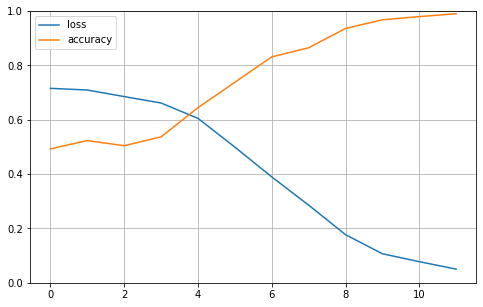


2023-03-16 01:23:47.324276

Testing # 1 1
2023-03-16 01:23:47.324682
2023-03-16 01:23:47.324722
PREDICT
2023-03-16 01:23:47.541985
Test 1:0 738:104 87.65%
Predict 1:0 805:37 95.61%
Test sizes (842, 4997) (842,)
Range of scores: 2.1293858e-05 to 1.0
Score threshold 0.5


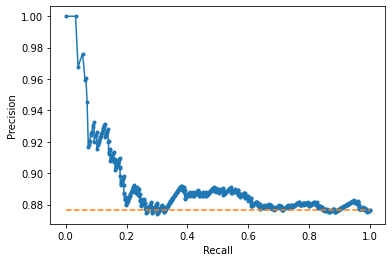

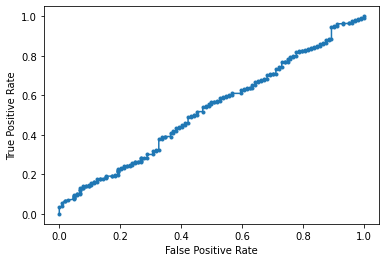

Accuracy: 85.39% Precision: 88.20% Recall: 96.21%
F1: 92.03% MCC: 0.08%
AUPRC: 89.35% AUROC: 52.81%
 accuracy [85.39192399049881]
 precision [88.19875776397515]
 recall [96.2059620596206]
 F1 [92.02851587815944]
 MCC [0.07801267665619233]
 AUPRC [89.34810439571497]
 AUROC [52.80774442359808]
2023-03-16 01:23:48.800015

Training # 1 2
2023-03-16 01:23:48.801598
2023-03-16 01:23:48.802305
Discriminator is GMM
Means [1.9181956869302774, -0.302109113505207]
Variances [2.64117518 8.57207465]
Priors [0.66118711 0.33881289]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
FIT
2023-03-16 01:23:53.246366


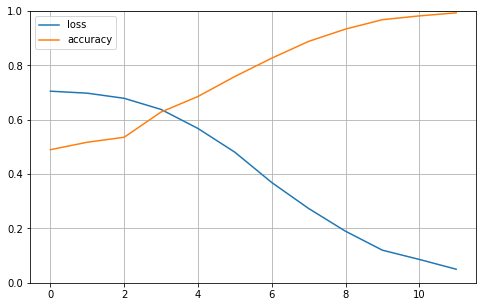


2023-03-16 01:24:07.035952

Testing # 1 2
2023-03-16 01:24:07.036057
2023-03-16 01:24:07.036098
PREDICT
2023-03-16 01:24:07.387643
Test 1:0 728:126 85.25%
Predict 1:0 673:181 78.81%
Test sizes (854, 4997) (854,)
Range of scores: 1.9720677e-05 to 1.0
Score threshold 0.5


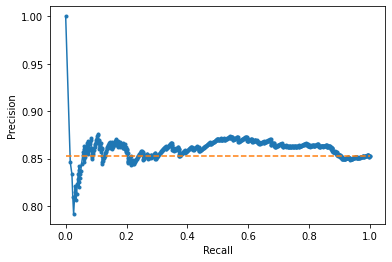

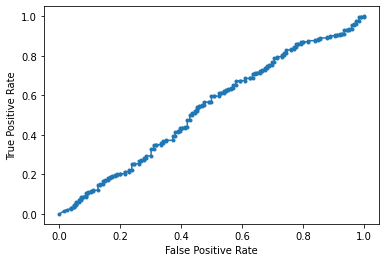

Accuracy: 72.01% Precision: 86.33% Recall: 79.81%
F1: 82.94% MCC: 0.06%
AUPRC: 86.06% AUROC: 53.34%
 accuracy [72.01405152224825]
 precision [86.32986627043091]
 recall [79.8076923076923]
 F1 [82.94075660242684]
 MCC [0.058937303876400476]
 AUPRC [86.06041496640402]
 AUROC [53.34031048316762]
2023-03-16 01:24:08.440820

Training # 1 3
2023-03-16 01:24:08.441711
2023-03-16 01:24:08.441769
Discriminator is GMM
Means [2.1354710069417213, -0.06451606218090697]
Variances [2.33843511 6.39135988]
Priors [0.58775009 0.41224991]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
FIT
2023-03-16 01:24:10.775391


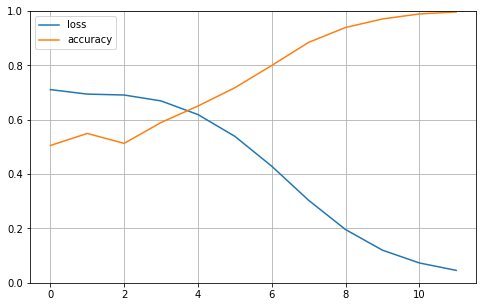


2023-03-16 01:24:25.510578

Testing # 1 3
2023-03-16 01:24:25.511937
2023-03-16 01:24:25.512257
PREDICT
2023-03-16 01:24:25.722081
Test 1:0 581:248 70.08%
Predict 1:0 591:238 71.29%
Test sizes (829, 4997) (829,)
Range of scores: 2.92002e-07 to 1.0
Score threshold 0.5


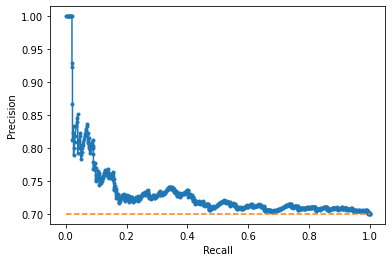

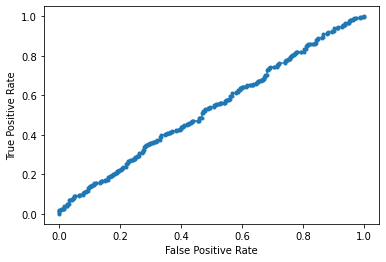

Accuracy: 60.43% Precision: 71.40% Recall: 72.63%
F1: 72.01% MCC: 0.05%
AUPRC: 73.21% AUROC: 53.16%
 accuracy [60.43425814234017]
 precision [71.40439932318104]
 recall [72.63339070567987]
 F1 [72.0136518771331]
 MCC [0.04542623417309958]
 AUPRC [73.2118592137722]
 AUROC [53.15709843984232]
2023-03-16 01:24:26.744671

Training # 1 4
2023-03-16 01:24:26.745002
2023-03-16 01:24:26.745066
Discriminator is GMM
Means [-0.27496887389276037, 1.9368832937938523]
Variances [8.43673025 2.60594976]
Priors [0.32913589 0.67086411]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
FIT
2023-03-16 01:24:31.508076


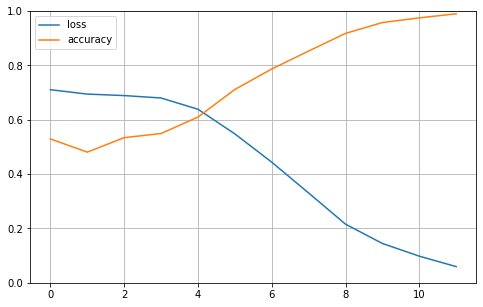


2023-03-16 01:24:45.251558

Testing # 1 4
2023-03-16 01:24:45.251663
2023-03-16 01:24:45.251711
PREDICT
2023-03-16 01:24:45.465455
Test 1:0 709:153 82.25%
Predict 1:0 753:109 87.35%
Test sizes (862, 4997) (862,)
Range of scores: 0.0006570497 to 1.0
Score threshold 0.5


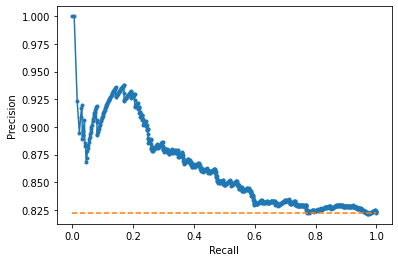

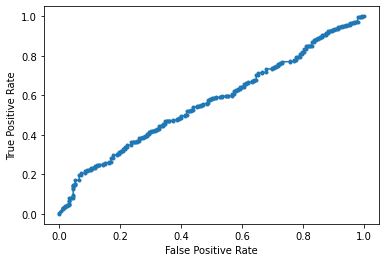

Accuracy: 75.17% Precision: 82.87% Recall: 88.01%
F1: 85.36% MCC: 0.04%
AUPRC: 86.30% AUROC: 56.59%
 accuracy [75.1740139211137]
 precision [82.86852589641434]
 recall [88.01128349788434]
 F1 [85.36251709986318]
 MCC [0.04250823686649805]
 AUPRC [86.30052326293114]
 AUROC [56.59218083095956]
2023-03-16 01:24:46.536168

Training # 1 5
2023-03-16 01:24:46.536369
2023-03-16 01:24:46.536440
Discriminator is GMM
Means [2.0251882414569384, -0.2639088514137343]
Variances [2.54334608 7.6624549 ]
Priors [0.6387231 0.3612769]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
FIT
2023-03-16 01:24:48.741314


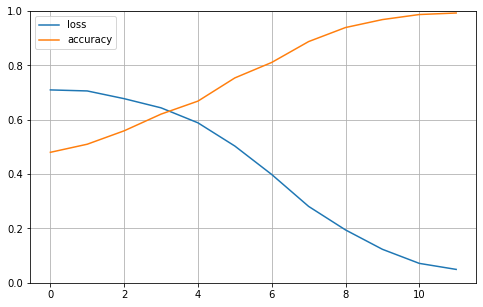


2023-03-16 01:25:02.602469

Testing # 1 5
2023-03-16 01:25:02.602560
2023-03-16 01:25:02.602609
PREDICT
2023-03-16 01:25:02.817041
Test 1:0 687:162 80.92%
Predict 1:0 672:177 79.15%
Test sizes (849, 4997) (849,)
Range of scores: 2.3333691e-06 to 1.0
Score threshold 0.5


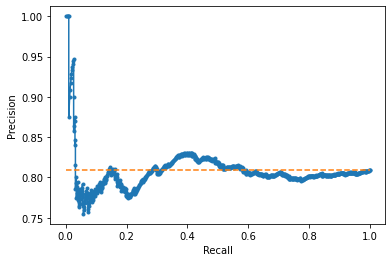

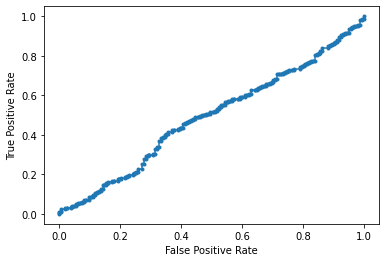

Accuracy: 66.20% Precision: 79.76% Recall: 78.02%
F1: 78.88% MCC: -0.06%
AUPRC: 80.84% AUROC: 49.07%
 accuracy [66.19552414605418]
 precision [79.76190476190477]
 recall [78.02037845705968]
 F1 [78.88153053715968]
 MCC [-0.05736365167846476]
 AUPRC [80.84179802409842]
 AUROC [49.07182777148814]
2023-03-16 01:25:03.882851

Training # 2 1
2023-03-16 01:25:03.884639
2023-03-16 01:25:03.884701
Discriminator is GMM
Means [2.0462126249228514, -0.26507185127943605]
Variances [2.44828978 7.25911297]
Priors [0.64537279 0.35462721]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
FIT
2023-03-16 01:25:06.057761


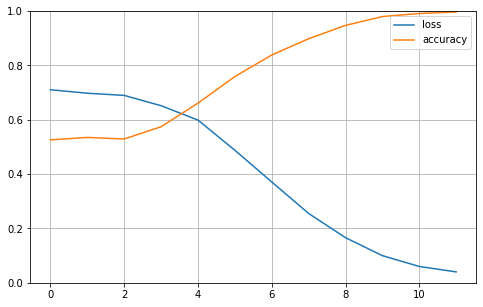


2023-03-16 01:25:19.822352

Testing # 2 1
2023-03-16 01:25:19.822446
2023-03-16 01:25:19.822487
PREDICT
2023-03-16 01:25:20.039857
Test 1:0 655:202 76.43%
Predict 1:0 713:144 83.20%
Test sizes (857, 4997) (857,)
Range of scores: 2.0518313e-05 to 1.0
Score threshold 0.5


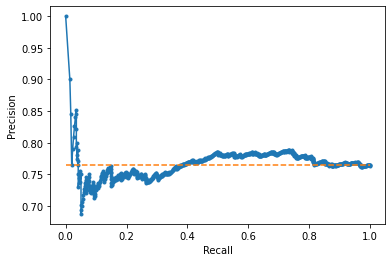

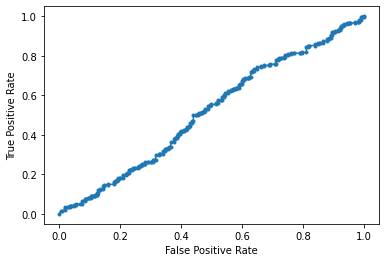

Accuracy: 68.49% Precision: 77.00% Recall: 83.82%
F1: 80.26% MCC: 0.03%
AUPRC: 76.85% AUROC: 51.75%
 accuracy [68.49474912485414]
 precision [76.99859747545582]
 recall [83.81679389312977]
 F1 [80.26315789473684]
 MCC [0.02984057806749443]
 AUPRC [76.84944350666774]
 AUROC [51.7511903862142]
2023-03-16 01:25:21.088886

Training # 2 2
2023-03-16 01:25:21.089112
2023-03-16 01:25:21.089165
Discriminator is GMM
Means [1.870166143114737, -0.25485855342015645]
Variances [2.67316377 8.62738824]
Priors [0.67637419 0.32362581]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
FIT
2023-03-16 01:25:25.368458


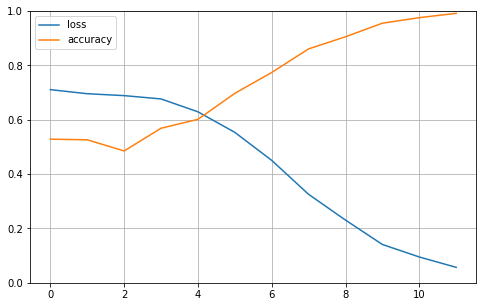


2023-03-16 01:25:39.156620

Testing # 2 2
2023-03-16 01:25:39.156725
2023-03-16 01:25:39.156766
PREDICT
2023-03-16 01:25:39.385427
Test 1:0 708:141 83.39%
Predict 1:0 767:82 90.34%
Test sizes (849, 4997) (849,)
Range of scores: 0.0014505431 to 1.0
Score threshold 0.5


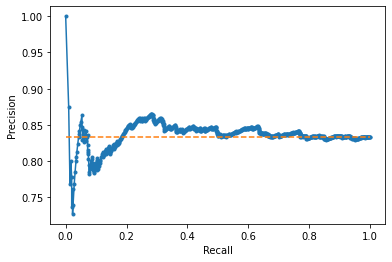

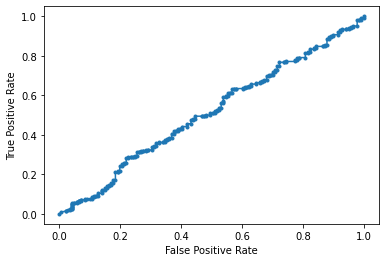

Accuracy: 77.03% Precision: 83.44% Recall: 90.40%
F1: 86.78% MCC: 0.00%
AUPRC: 83.68% AUROC: 51.33%
 accuracy [77.03180212014135]
 precision [83.44198174706649]
 recall [90.3954802259887]
 F1 [86.77966101694913]
 MCC [0.004088972755248399]
 AUPRC [83.6822692335051]
 AUROC [51.33329326441479]
2023-03-16 01:25:40.423121

Training # 2 3
2023-03-16 01:25:40.423323
2023-03-16 01:25:40.423378
Discriminator is GMM
Means [-0.2758857846112329, 1.949621094718331]
Variances [8.45538493 2.63051931]
Priors [0.33374703 0.66625297]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
FIT
2023-03-16 01:25:42.940084


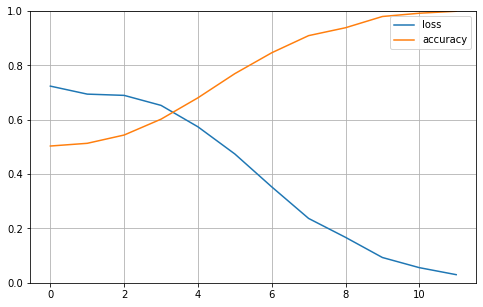


2023-03-16 01:25:57.252887

Testing # 2 3
2023-03-16 01:25:57.252991
2023-03-16 01:25:57.253031
PREDICT
2023-03-16 01:25:57.461524
Test 1:0 680:146 82.32%
Predict 1:0 723:103 87.53%
Test sizes (826, 4997) (826,)
Range of scores: 2.0741745e-05 to 1.0
Score threshold 0.5


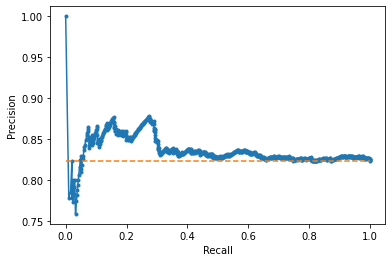

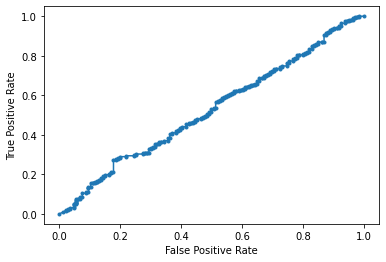

Accuracy: 74.46% Precision: 82.43% Recall: 87.65%
F1: 84.96% MCC: 0.01%
AUPRC: 83.59% AUROC: 52.78%
 accuracy [74.45520581113801]
 precision [82.43430152143844]
 recall [87.6470588235294]
 F1 [84.96079828937991]
 MCC [0.0076293088105064185]
 AUPRC [83.59466399152748]
 AUROC [52.78404512489927]
2023-03-16 01:25:58.536380

Training # 2 4
2023-03-16 01:25:58.536599
2023-03-16 01:25:58.536654
Discriminator is GMM
Means [1.9217767995079464, -0.2738435424810465]
Variances [2.66801201 8.46249649]
Priors [0.66551019 0.33448981]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
FIT
2023-03-16 01:26:03.379892


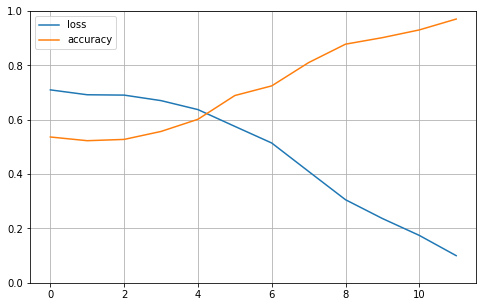


2023-03-16 01:26:24.997064

Testing # 2 4
2023-03-16 01:26:24.998761
2023-03-16 01:26:24.999144
PREDICT
2023-03-16 01:26:25.218737
Test 1:0 735:125 85.47%
Predict 1:0 725:135 84.30%
Test sizes (860, 4997) (860,)
Range of scores: 0.000102088976 to 1.0
Score threshold 0.5


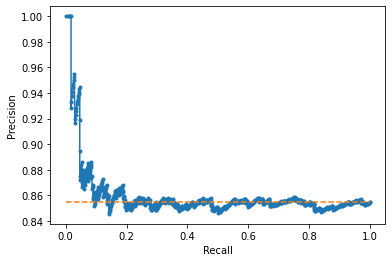

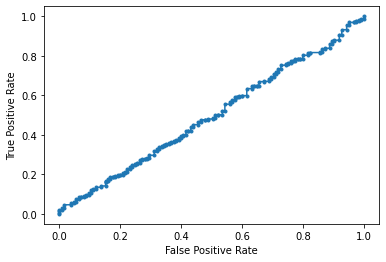

Accuracy: 73.49% Precision: 84.97% Recall: 83.81%
F1: 84.38% MCC: -0.03%
AUPRC: 86.02% AUROC: 49.72%
 accuracy [73.48837209302326]
 precision [84.9655172413793]
 recall [83.80952380952381]
 F1 [84.38356164383562]
 MCC [-0.03284910091992381]
 AUPRC [86.01576452352285]
 AUROC [49.72244897959184]
2023-03-16 01:26:26.428867

Training # 2 5
2023-03-16 01:26:26.429734
2023-03-16 01:26:26.429788
Discriminator is GMM
Means [1.9768664210853615, -0.131429256815772]
Variances [2.50963714 7.66511953]
Priors [0.63132841 0.36867159]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
FIT
2023-03-16 01:26:30.795702


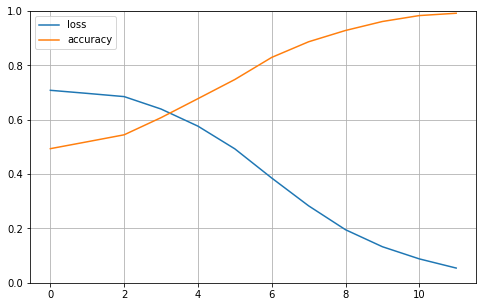


2023-03-16 01:26:52.338516

Testing # 2 5
2023-03-16 01:26:52.338630
2023-03-16 01:26:52.338674
PREDICT
2023-03-16 01:26:52.548553
Test 1:0 664:180 78.67%
Predict 1:0 682:162 80.81%
Test sizes (844, 4997) (844,)
Range of scores: 3.9330266e-06 to 1.0
Score threshold 0.5


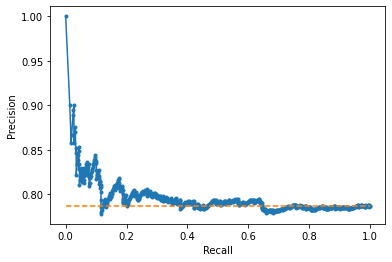

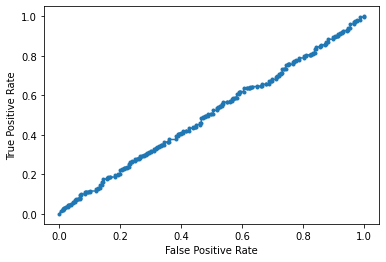

Accuracy: 67.06% Precision: 78.30% Recall: 80.42%
F1: 79.35% MCC: -0.02%
AUPRC: 79.68% AUROC: 50.48%
 accuracy [67.06161137440758]
 precision [78.2991202346041]
 recall [80.42168674698796]
 F1 [79.34621099554235]
 MCC [-0.018727175487123313]
 AUPRC [79.68332560749974]
 AUROC [50.47607095046855]
2023-03-16 01:26:53.427494


In [11]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_sequence(filepath)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_sequence(filepath)
    print('Loaded',len(test_allseq),'sequences.')

REPEATS = 2
FOLDS = 5
for repeat in range(REPEATS):
    for fold in range(FOLDS):
        r = repeat+1
        f = fold+1

        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,r,f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            
        print(datetime.now())
        print()
        print("Training #",r,f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS,BREAK)
        cvdo.set_sequences(train_allids,train_allseq)
        cvdo.set_rci_map(train_gene_to_rci)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        cvdo.train_new_model()

        print()
        print(datetime.now())
        print()
        print("Testing #",r,f)
        print(datetime.now())
        cvdo.set_sequences(test_allids,test_allseq)
        cvdo.set_rci_map(test_gene_to_rci)
        cvdo.reset_statistics()
        cvdo.test_without_training()
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [12]:
def STD (values):
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.2f%% std %.2f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 71.97% std 6.89
 precision mean 81.47% std 4.97
 recall mean 84.08% std 6.79
 F1 mean 82.70% std 5.42
 MCC mean 0.02% std 0.04
 AUPRC mean 82.56% std 4.92
 AUROC mean 52.10% std 2.16
 accuracy [[85.39192399049881], [72.01405152224825], [60.43425814234017], [75.1740139211137], [66.19552414605418], [68.49474912485414], [77.03180212014135], [74.45520581113801], [73.48837209302326], [67.06161137440758]]
 precision [[88.19875776397515], [86.32986627043091], [71.40439932318104], [82.86852589641434], [79.76190476190477], [76.99859747545582], [83.44198174706649], [82.43430152143844], [84.9655172413793], [78.2991202346041]]
 recall [[96.2059620596206], [79.8076923076923], [72.63339070567987], [88.01128349788434], [78.02037845705968], [83.81679389312977], [90.3954802259887], [87.6470588235294], [83.80952380952381], [80.42168674698796]]
 F1 [[92.02851587815944], [82.94075660242684], [72.0136518771331], [85.36251709986318], [78.88153053715968], [80.26315789473684], [86.7796610169491